# TRAIN and VALIDATION


## Load the images and labels from local files

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2

# Load the data from the json file
images = []
labels = []

dataset_path = 'datasets/dataset_184539030224/data.json'

with open(dataset_path, 'r') as labels_file:
    for line in labels_file:
        data = json.loads(line)
        images.append(data['image'])
        labels.append(data['label'])


print(images[0:3])
print(labels[0:3])



['./datasets/dataset_184539030224/images/image_front_0.jpg', './datasets/dataset_184539030224/images/image_left_1.jpg', './datasets/dataset_184539030224/images/image_right_2.jpg']
[0.0, 2.5, -2.5]


## Analyze the data

Steering angle statistics
Mean:  0.12925004067024565
Standard deviation:  3.017253834195166
Max:  11.75
Min:  -8.5


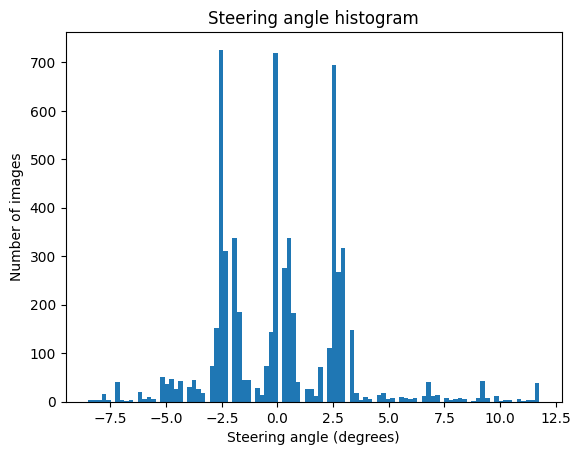

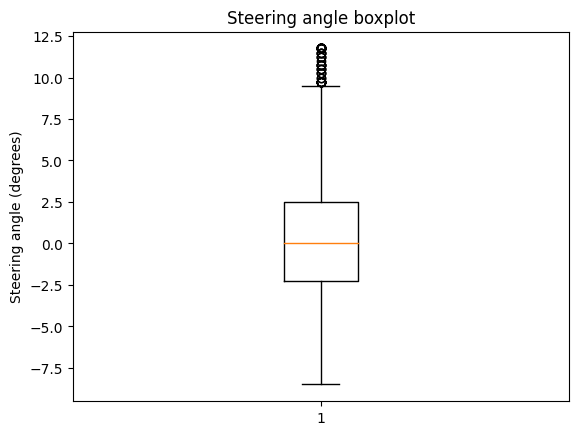

In [3]:
# Steering angle statistics
print('Steering angle statistics')
print('Mean: ', np.mean(labels))
print('Standard deviation: ', np.std(labels))
print('Max: ', np.max(labels))
print('Min: ', np.min(labels))

# Steering angle histogram
plt.hist(labels, bins=100)
plt.title('Steering angle histogram')
plt.xlabel('Steering angle (degrees)')
plt.ylabel('Number of images')
plt.show()

# Plot candle stick chart
plt.boxplot(labels)
plt.title('Steering angle boxplot')
plt.ylabel('Steering angle (degrees)')
plt.show()

## Preprocess the data

Steering angle statistics after normalization
Mean:  0.426135804477543
Standard deviation:  0.14900018934297116
Max:  1.0
Min:  0.0


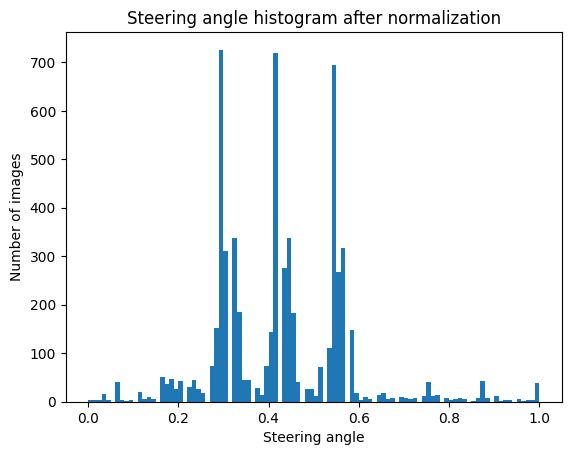

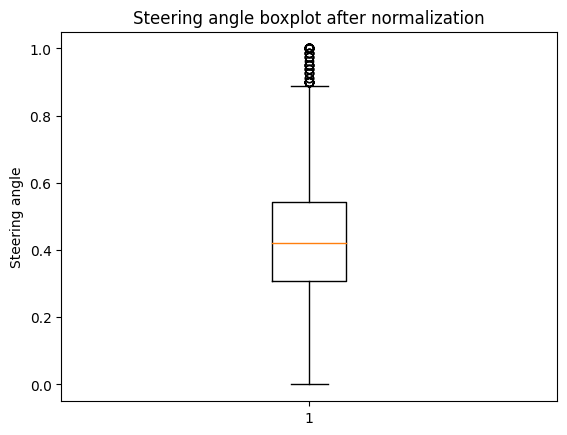

In [4]:
# Normalize steering angles to be between 0 and 1
labels = np.array(labels)
labels_min = np.min(labels)
labels_max = np.max(labels)

labels_norm = (labels - labels_min) / (labels_max - labels_min)

print('Steering angle statistics after normalization')
print('Mean: ', np.mean(labels_norm))
print('Standard deviation: ', np.std(labels_norm))
print('Max: ', np.max(labels_norm))
print('Min: ', np.min(labels_norm))

# Steering angle histogram
plt.hist(labels_norm, bins=100)
plt.title('Steering angle histogram after normalization')
plt.xlabel('Steering angle')
plt.ylabel('Number of images')
plt.show()

# Plot candle stick chart
plt.boxplot(labels_norm)
plt.title('Steering angle boxplot after normalization')
plt.ylabel('Steering angle')
plt.show()

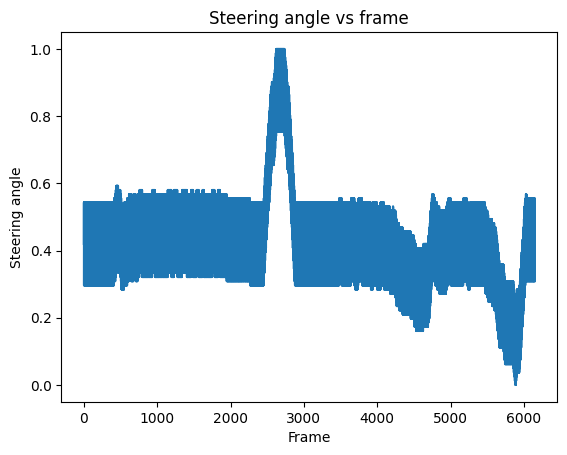

In [5]:
# Print a plot of the steering angle vs the image
figure = plt.figure()
plt.title('Steering angle vs frame')
plt.plot(labels_norm)
plt.xlabel('Frame')
plt.ylabel('Steering angle')
plt.show()

Use the cell below if you want to filter the steering angles of the data, in order to reduce noise and make the transitions smoother and potentially improve performance

In [6]:
# # Make the steering angle smoother
# labels_norm_smooth = np.convolve(labels_norm, np.ones((75))/75, mode='valid')

# # Print a plot of the steering angle vs the image
# figure = plt.figure()
# plt.title('Steering angle vs frame after smoothing')
# plt.plot(labels_norm_smooth)
# plt.xlabel('Frame')
# plt.ylabel('Steering angle')
# plt.show()

# # Steering angle histogram
# plt.hist(labels_norm_smooth, bins=100)
# plt.title('Steering angle histogram after smoothing')
# plt.xlabel('Steering angle')
# plt.ylabel('Number of Images')
# plt.show()

## Create dataset and dataloaders for training and validation

In [7]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class CarlaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


## Visualize some raw images

(376, 1344, 3) 0.41975308641975306


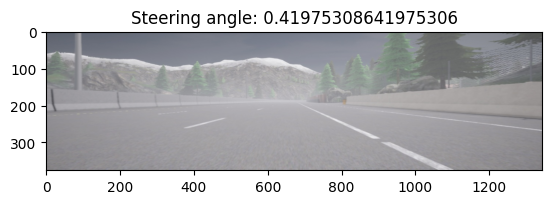

(376, 1344, 3) 0.5432098765432098


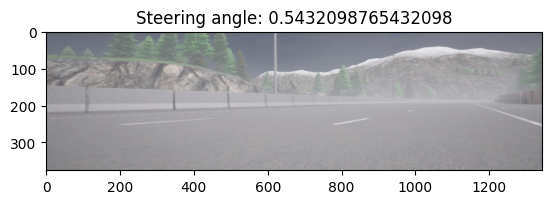

(376, 1344, 3) 0.2962962962962963


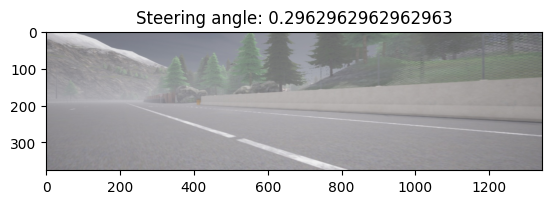

In [8]:
# Show some images withoout any transformation
dataset = CarlaDataset(images, labels_norm) #labels_norm_smooth
fig = plt.figure()

# Show random samples
for i in range(150,153):
    image, label = dataset[i]
    print(image.shape, label)
    plt.imshow(image)
    plt.title('Steering angle: ' + str(label))
    plt.savefig('Figures/' + str(i) + '.png')
    plt.show()


## Create a dataset using transformations

The images will be resized and normalized

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


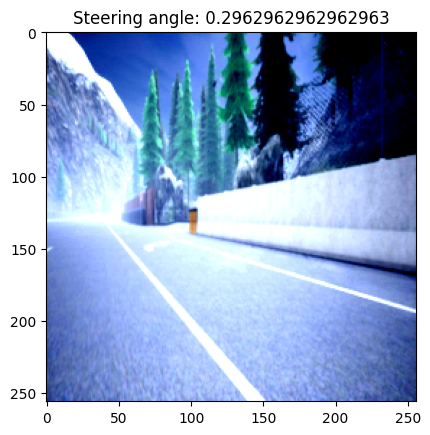

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


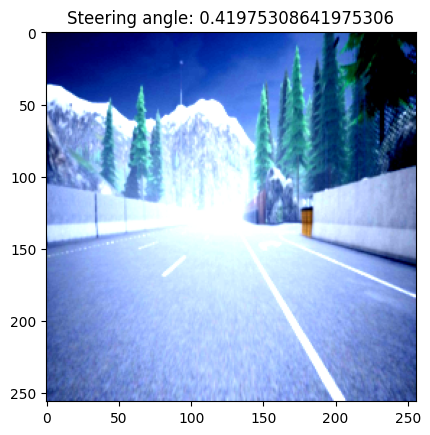

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


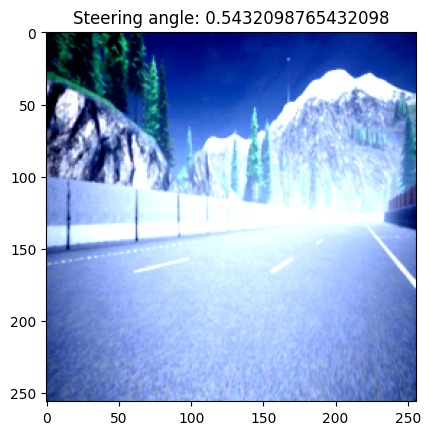

In [9]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
dataset = CarlaDataset(images, labels_norm, transform=transform)

# Show some examples
for i in {200,201,202}:
    image, label = dataset[i]
    plt.title('Steering angle: ' + str(label))
    plt.imshow(image.permute(1, 2, 0)) # Convert from CxHxW to HxWxC to use matplotlib
    plt.savefig('Figures/' + 'transf_' + str(i) + '.png')
    plt.show()


### Train and validation splits

In [10]:
# Create the training and validation dataloaders
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

### Train loop

In [11]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import datetime
import os



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train(model, train_loader, validation_loader, epochs, criterion, optimizer, patience=5):
    train_losses = []
    validation_losses = []
    best_val_loss = np.inf
    no_improve_epoch = 0

    now = datetime.datetime.now()
    pth_path = f'models/{model.name}_{now.strftime("%m%d_%H%M")}.pth'
    

    if not os.path.exists('models'):
        os.makedirs('models')

    for epoch in range(epochs):
        model.train()
        train_loss = []
        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')  
        for data, target in pbar:
            data = data.to(device)
            target = target.float().to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            pbar.set_postfix({'train_loss': np.mean(train_loss)})  
        train_loss = np.mean(train_loss)
        
        model.eval()
        validation_loss = []
        pbar = tqdm(validation_loader, desc=f'Validation Epoch {epoch}') 
        for data, target in pbar:
            data = data.to(device)
            target = target.float().to(device)
            outputs = model(data)
            loss = criterion(outputs, target.unsqueeze(1))
            validation_loss.append(loss.item())
            pbar.set_postfix({'validation_loss': np.mean(validation_loss)})
        validation_loss = np.mean(validation_loss)

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            no_improve_epoch = 0
            print('Saving the model')
            torch.save(model.state_dict(), pth_path)
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                print('Early stopping')
                break
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        
        print(f'Epoch {epoch}, train loss: {train_loss}, validation loss: {validation_loss}')
        
    return train_losses, validation_losses

### Model definition

In [12]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__ (self):
        super(Net, self).__init__()
        self.name = 'Net'

        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, 5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)
        
        self.fc1 = nn.Linear(64*25*25, 100) # Change this in case you change the image size (256x256)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.out = nn.Linear(10, 1)
        
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.out(x)

        return x


In [13]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.name = 'SimpleNet'
        
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        
        self.fc1 = nn.Linear(36*61*61, 100)
        self.fc2 = nn.Linear(100, 50)
        self.out = nn.Linear(50, 1)
        
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

### Build and train the model

In [14]:
# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# Select the model 
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=40000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [16]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
train_losses, validation_losses = train(model, train_loader, validation_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, patience=5)

Validation Epoch 0: 100%|██████████| 39/39 [00:12<00:00,  3.04it/s, validation_loss=0.00494]


Saving the model
Epoch 0, train loss: 0.01231161776821238, validation loss: 0.004937758782687478


Validation Epoch 1: 100%|██████████| 39/39 [00:12<00:00,  3.15it/s, validation_loss=0.00122]


Saving the model
Epoch 1, train loss: 0.003486916358588723, validation loss: 0.001215002693546315


Validation Epoch 2: 100%|██████████| 39/39 [00:12<00:00,  3.13it/s, validation_loss=0.000605]


Saving the model
Epoch 2, train loss: 0.0015861415761589473, validation loss: 0.0006049155714348531


Validation Epoch 3: 100%|██████████| 39/39 [00:12<00:00,  3.19it/s, validation_loss=0.000698]


Epoch 3, train loss: 0.001018453155630631, validation loss: 0.0006983652046750275


Validation Epoch 4: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s, validation_loss=0.000539]


Saving the model
Epoch 4, train loss: 0.0007250879536112227, validation loss: 0.0005386865650040981


Validation Epoch 5: 100%|██████████| 39/39 [00:12<00:00,  3.04it/s, validation_loss=0.000453]


Saving the model
Epoch 5, train loss: 0.0008926085716524681, validation loss: 0.0004525272972666873


Validation Epoch 6: 100%|██████████| 39/39 [00:12<00:00,  3.07it/s, validation_loss=0.000312]


Saving the model
Epoch 6, train loss: 0.0005861700123346822, validation loss: 0.00031159670489171567


Validation Epoch 7: 100%|██████████| 39/39 [00:12<00:00,  3.21it/s, validation_loss=0.000511]


Epoch 7, train loss: 0.0005497474942655702, validation loss: 0.0005108286113215563


Validation Epoch 8: 100%|██████████| 39/39 [00:12<00:00,  3.20it/s, validation_loss=0.000536]


Epoch 8, train loss: 0.0005843964809409718, validation loss: 0.0005355381473260096


Validation Epoch 9: 100%|██████████| 39/39 [00:12<00:00,  3.02it/s, validation_loss=0.000435]


Epoch 9, train loss: 0.0004975372024315905, validation loss: 0.0004348954982840671


Validation Epoch 10: 100%|██████████| 39/39 [00:12<00:00,  3.22it/s, validation_loss=0.000269]


Saving the model
Epoch 10, train loss: 0.00048283016629095264, validation loss: 0.0002689737039662969


Validation Epoch 11: 100%|██████████| 39/39 [00:11<00:00,  3.27it/s, validation_loss=0.000208]


Saving the model
Epoch 11, train loss: 0.0004052819836564973, validation loss: 0.00020776710731204218


Validation Epoch 12: 100%|██████████| 39/39 [00:11<00:00,  3.48it/s, validation_loss=0.000198]


Saving the model
Epoch 12, train loss: 0.00040517643275678265, validation loss: 0.00019757301505216255


Validation Epoch 13: 100%|██████████| 39/39 [00:11<00:00,  3.44it/s, validation_loss=0.000774]


Epoch 13, train loss: 0.00031706600868772086, validation loss: 0.000774445336085195


Validation Epoch 14: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s, validation_loss=0.000177]


Saving the model
Epoch 14, train loss: 0.0003525764847611978, validation loss: 0.0001773810309271376


Validation Epoch 15: 100%|██████████| 39/39 [00:11<00:00,  3.37it/s, validation_loss=0.000369]


Epoch 15, train loss: 0.0003257235312993508, validation loss: 0.00036915128126006143


Validation Epoch 16: 100%|██████████| 39/39 [00:11<00:00,  3.45it/s, validation_loss=0.000474]


Epoch 16, train loss: 0.00028330543987126417, validation loss: 0.0004744064421034776


Validation Epoch 17: 100%|██████████| 39/39 [00:11<00:00,  3.39it/s, validation_loss=0.00075] 


Epoch 17, train loss: 0.00041272544005149434, validation loss: 0.0007498359415107048


Validation Epoch 18: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s, validation_loss=0.000256]


Epoch 18, train loss: 0.00040363198384913226, validation loss: 0.00025551141012468946


Validation Epoch 19: 100%|██████████| 39/39 [00:11<00:00,  3.37it/s, validation_loss=0.000306]

Early stopping


#### Train visualization

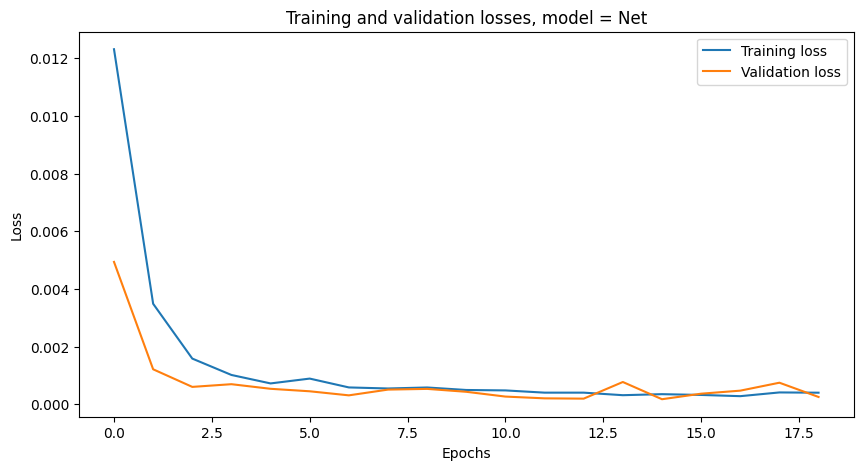

In [17]:
# Print history of losses
plt.figure(figsize=(10, 5))
plt.title('Training and validation losses, model = {}'.format(model.name))
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.ylabel('Loss') 
plt.xlabel('Epochs')  
plt.legend()

# save plot with model.name
plt.savefig('Figures/losses_{}.png'.format(model.name))
plt.show()


## Run prediction on the validation set

Select the model for the rest of the notebook

In [24]:
# Load the best model
model_path = "models/Net_0214_1149.pth"

# Load the model simplenet if is SimpleNet in the path
if 'SimpleNet' in model_path:
    model = SimpleNet().to(device)
else:
    model = Net().to(device)

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Select data to validate on

In [25]:
# Select dataloader
dataloader = train_loader

Testing: 100%|██████████| 154/154 [00:52<00:00,  2.94it/s]


Mean Absolute Error:  0.008231740569125448


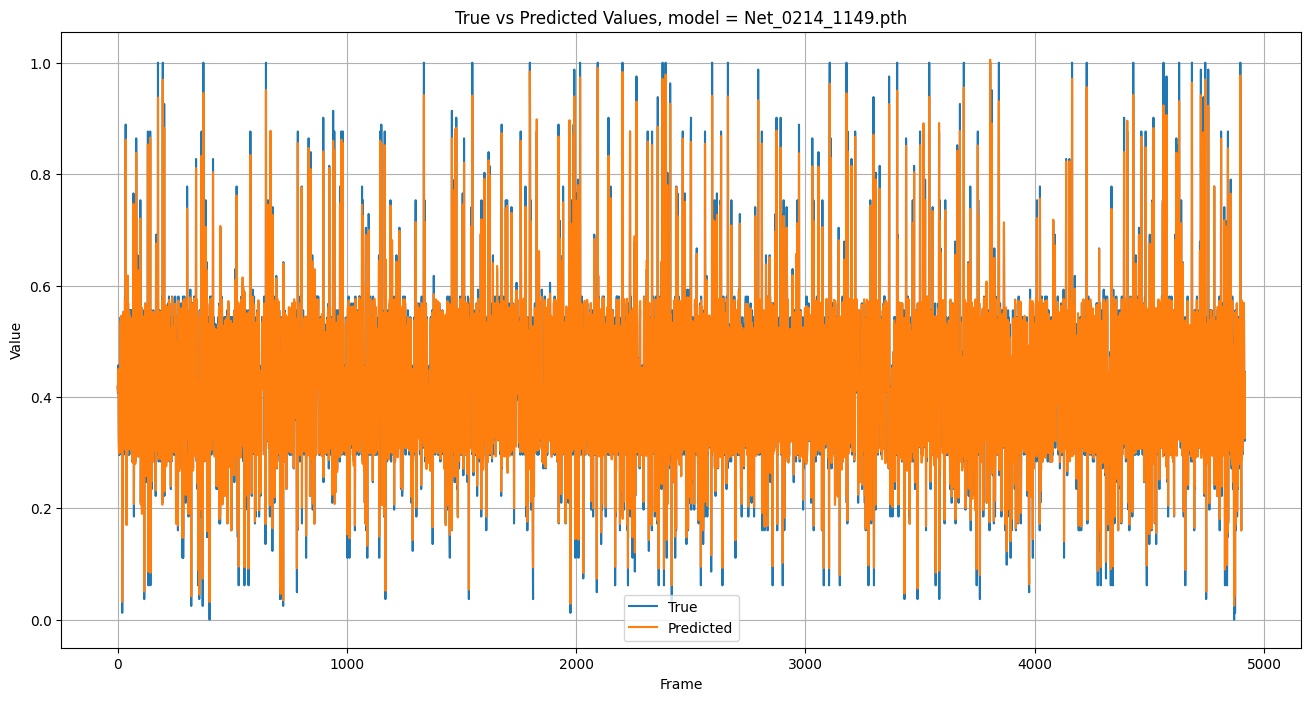

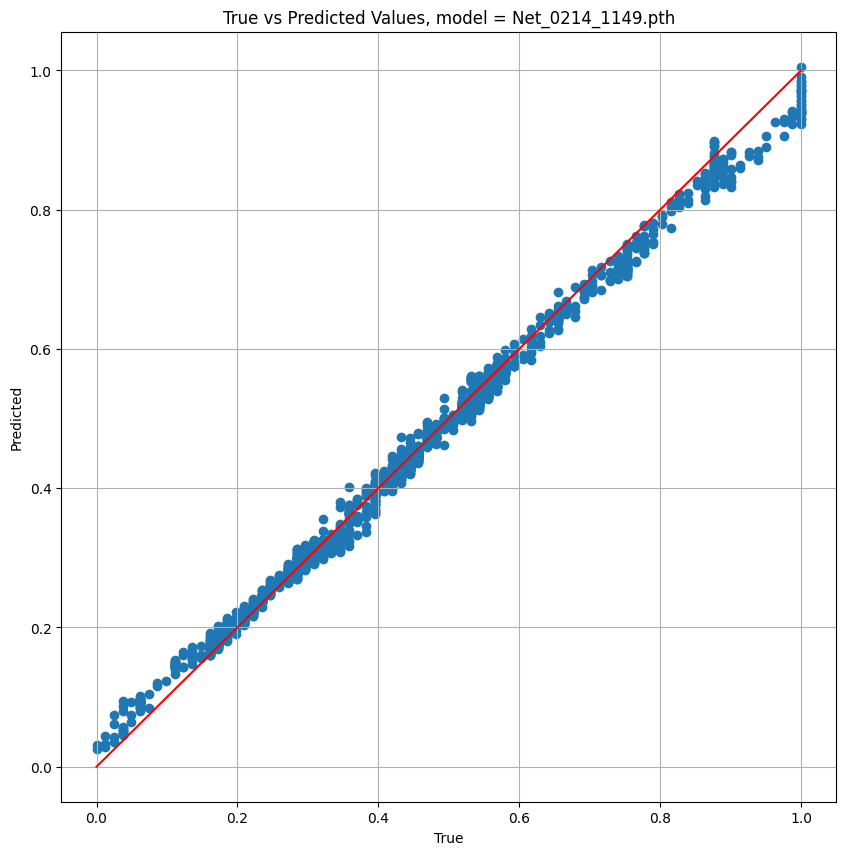

In [26]:
# Run predictions on the training set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for data, target in tqdm(dataloader, desc='Testing'):
        data = data.to(device)
        target = target.float().to(device)
        outputs = model(data)
        y_pred.extend(outputs.tolist())
        y_true.extend(target.tolist())

# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))

# Plot the predictions
plt.figure(figsize=(16,8))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.title(f'True vs Predicted Values, model = {model_path[7:]}') 
plt.xlabel('Frame') 
plt.ylabel('Value')  
plt.grid(True) 
plt.legend()
# save plot 
plt.savefig(f'Figures/predictions_{model_path[7:]}.png')
plt.show()


# Plot the predictions against true values and a line with slope 1
plt.figure(figsize=(10,10))
plt.scatter(y_true, y_pred)
plt.plot([0, 1], [0, 1], color='red')
plt.title(f'True vs Predicted Values, model = {model_path[7:]}') 
plt.xlabel('True')  
plt.ylabel('Predicted')  
plt.grid(True)  
# save plot 
plt.savefig(f'Figures/fitness_{model_path[7:]}.png')
plt.show()


#### Feature maps representation

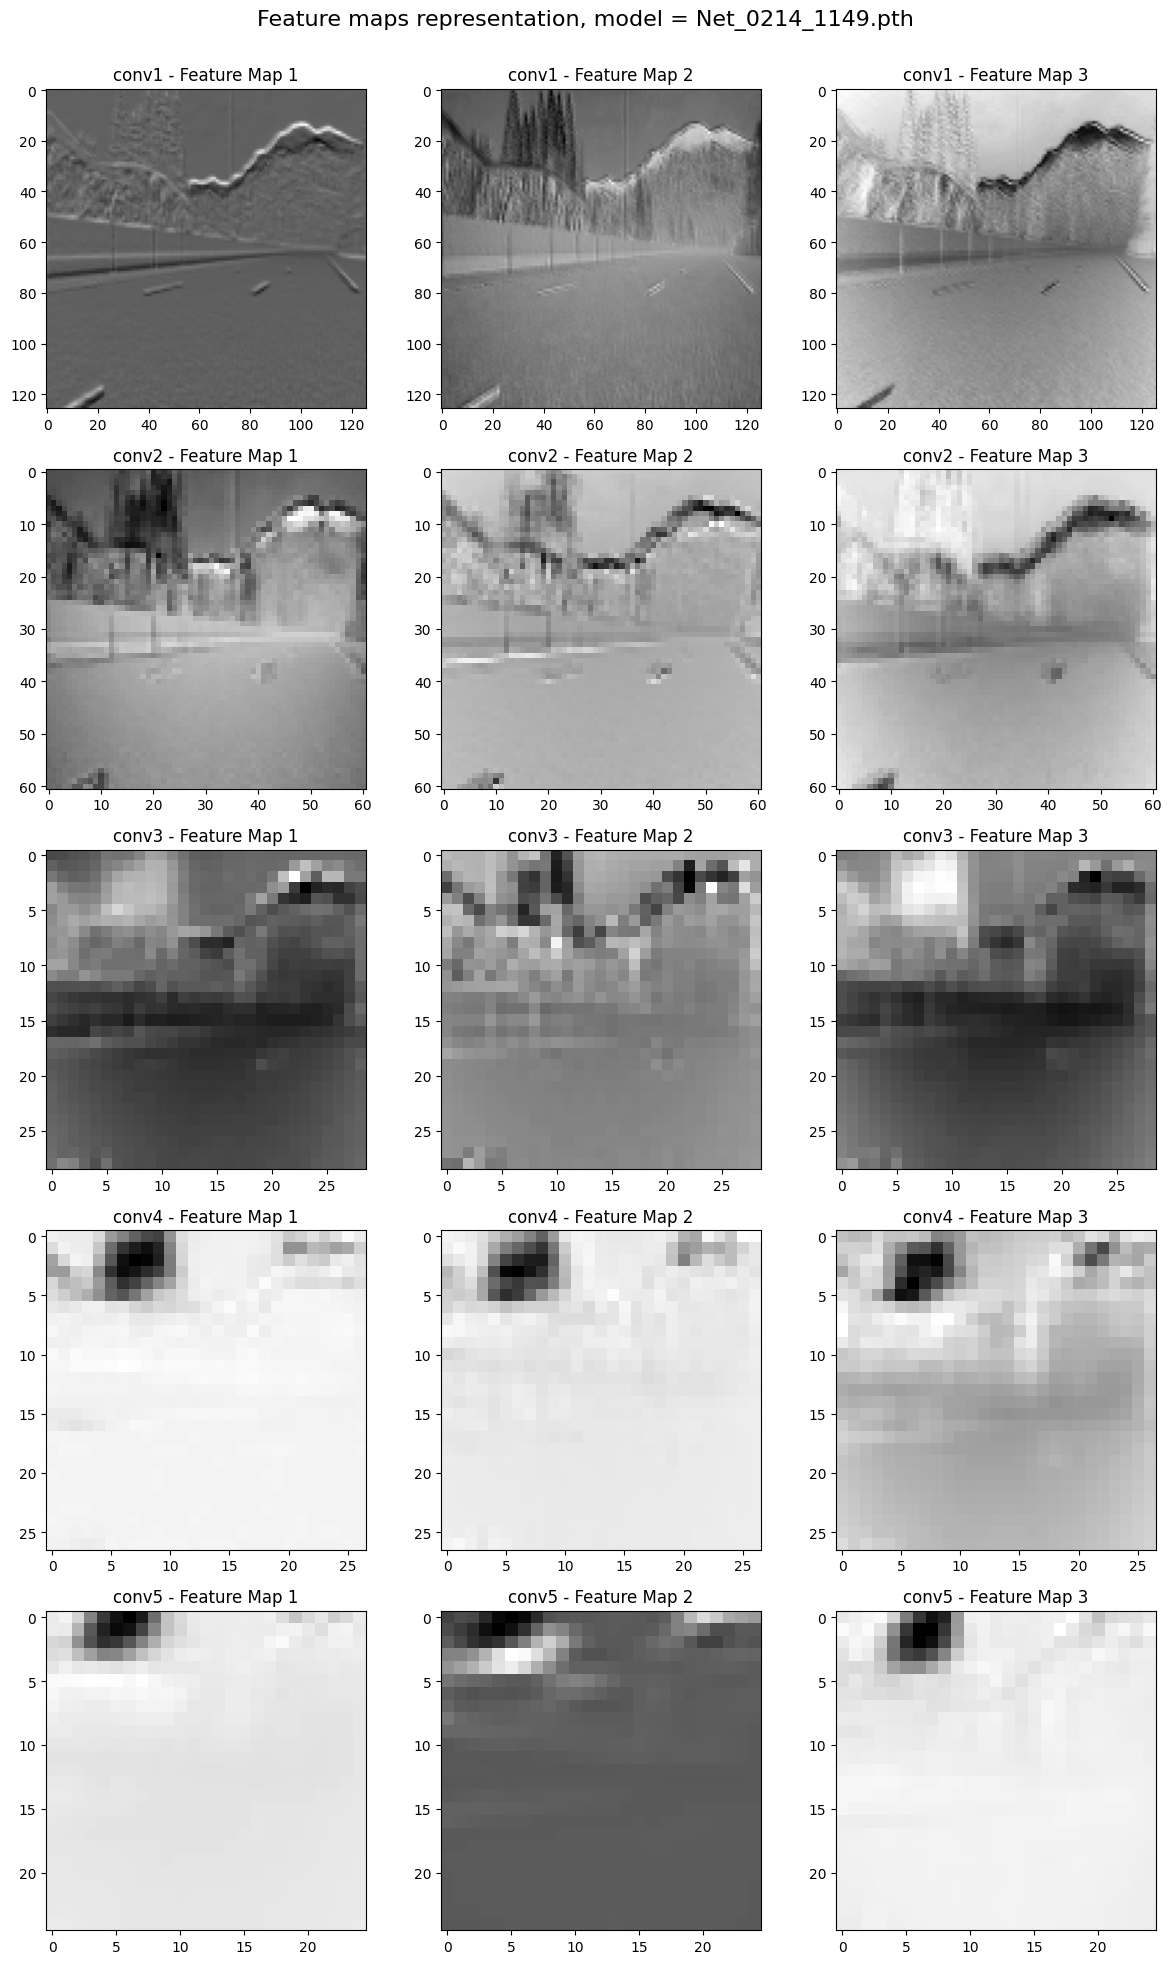

In [27]:
# Visualize activations of different layers
from torch.autograd import Variable

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Attach hooks to the layers
activation = {}

if 'SimpleNet' in model_path:
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.conv2.register_forward_hook(get_activation('conv2'))
else:
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.conv2.register_forward_hook(get_activation('conv2'))
    model.conv3.register_forward_hook(get_activation('conv3'))
    model.conv4.register_forward_hook(get_activation('conv4'))
    model.conv5.register_forward_hook(get_activation('conv5'))


# Select a random image
image, label = dataset[100]
image = image.unsqueeze(0).to(device)

# Run the image through the model
model.eval()
with torch.no_grad():
    output = model(image)

# Visualize the activations
fig, axs = plt.subplots(len(activation), 3, figsize=(12, len(activation)*4))
fig.suptitle(f'Feature maps representation, model = {model_path[7:]} \n \n', fontsize=16)
for i, (key, value) in enumerate(activation.items()):
    value = value.squeeze().to("cpu")
    # Select the first three feature maps
    for j in range(3):
        if len(value.shape) > 0:
            axs[i, j].imshow(value[j], cmap='gray')
            axs[i, j].set_title(f'{key} - Feature Map {j+1}')
plt.tight_layout()
# Save plot 
fig.savefig(f'Figures/feature_maps_{model_path[7:]}.png')
plt.show()

#### Saliency maps visualization

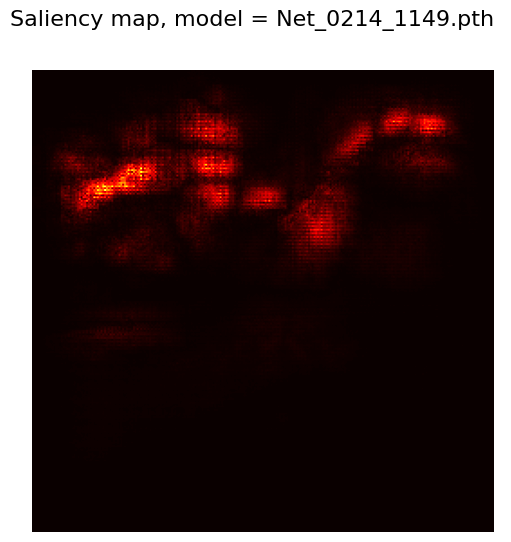

In [28]:
# Ensure the image requires gradient
if not image.requires_grad:
    image.requires_grad_()

# Forward and backward passes
with torch.enable_grad():
    output = model(image)
    model.zero_grad()
    output.backward()

# Convert the image gradients into a numpy array
gradients = image.grad.data.squeeze().cpu().numpy()

# Take the absolute value of gradients and then normalize them
saliency = np.abs(gradients).max(axis=0)

# Check for zero gradient
if np.max(saliency) != np.min(saliency):
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))

# Plot the saliency map
fig = plt.figure(figsize=(6, 6))
fig.suptitle(f'Saliency map, model = {model_path[7:]} \n \n', fontsize=16)
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()
# Save plot
fig.savefig(f'Figures/saliency_map_{model_path[7:]}.png')

## Visualization with OpenCV

Code to visualize the images with the real and predicted steering angle, without controlling the car

In [33]:
# get only the images from the front camera with their respective labels
front_images = []
front_labels = []
for i in range(len(images)):
    if 'front' in images[i]:
        front_images.append(images[i])
        front_labels.append(labels[i])


In [54]:
# Choose what images to use for inference
inference_imgs = front_images # images paths
inference_labels = front_labels # raw labels

# Inference
inference_activated = True

y_pred = []


def visualize_interface(img, label, output):
        # Wrote the predicted steering angle in the image
        output_str = f"Predicted Steering Angle: {output:.2f}"
        cv2.putText(img, output_str, (75, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Draw steering wheel to visualize
        wheel_angle = -1 * 10 * output 
        center = (int(img.shape[1]/2), int(img.shape[0]/2))
        cv2.circle(img, center, 50, (0,0,255), 2)
        angle = np.deg2rad(90 - wheel_angle)
        x = int(center[0] + 50*np.cos(angle))
        y = int(center[1] + 50*np.sin(angle))
        cv2.line(img, center, (x,y), (0,0,255), 2)
        
        # Draw the bars to visualize the steering angle
        bar_height = int(abs(output) * 15)  
        bar_pos = 200 
        cv2.rectangle(img, (10, 50), (30, 350), (0,0,255), 2)  
        if output >= 0:
            cv2.rectangle(img, (10, bar_pos), (30, bar_pos - bar_height), (0,0,255), -1)
        else:
            cv2.rectangle(img, (10, bar_pos), (30, bar_pos + bar_height), (0,0,255), -1)

        bar_height = int(abs(label) * 15) 
        cv2.rectangle(img, (40, 50), (60, 350), (0,255,0), 2) 
        if label >= 0:
            cv2.rectangle(img, (40, bar_pos), (60, bar_pos - bar_height), (0,255,0), -1)
        else:
            cv2.rectangle(img, (40, bar_pos), (60, bar_pos + bar_height), (0,255,0), -1)
        
        # Write the real steering angle in the image
        label_str = f"Steering Angle: {label:.2f}"
        cv2.putText(img, label_str, (75, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Loop through the images
for i in range(len(inference_imgs)):
    img = cv2.imread(inference_imgs[i])
    label = inference_labels[i]

    # Preprocess the image
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    if inference_activated:       
        # Run the model
        output = model(image)
        output = output.item()

        # Denormalize the prediction
        output = output * (labels_max - labels_min) + labels_min

        # Append the prediction to the list
        y_pred.append(output)

        # Visualize the interface
        visualize_interface(img, label, output)
         
    cv2.imshow('Image', img)
    if cv2.waitKey(1) == ord('q'):
        cv2.imwrite('Figures/inference_' + str(i) +'.png', img)
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()


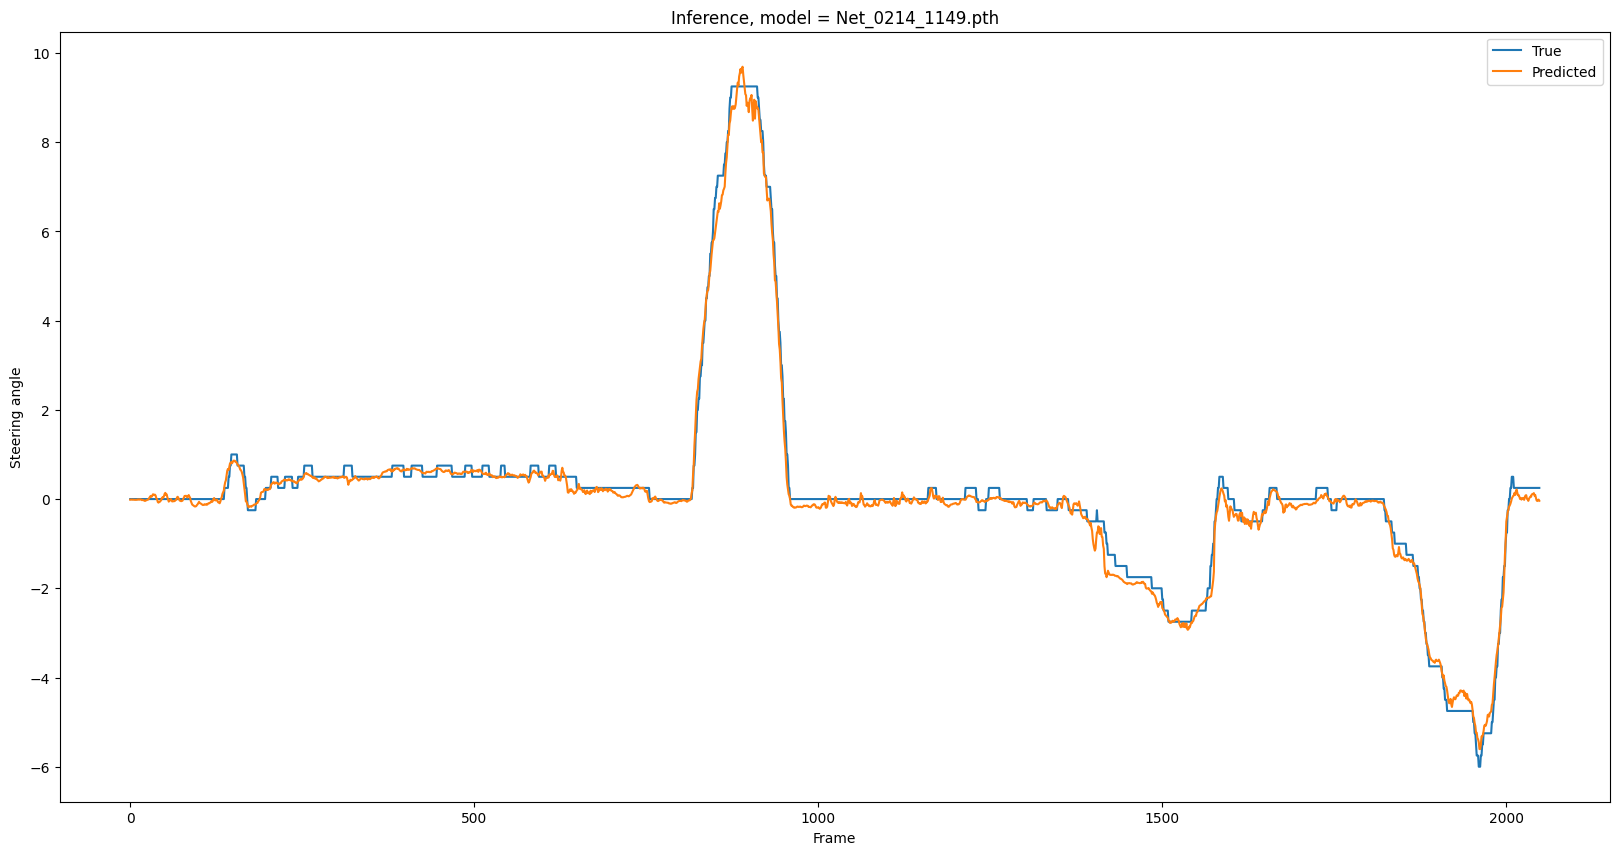

Mean Absolute Error:  0.1455939502440295


In [46]:
# Plot the predictions
plt.figure(figsize=(20,10))
# add title
plt.title(f'Inference, model = {model_path[7:]}')
plt.plot(inference_labels, label='True')
plt.plot(y_pred, label='Predicted')
# Labels for the plot
plt.xlabel('Frame')
plt.ylabel('Steering angle')
plt.legend()
# save plot
plt.savefig(f'Figures/inference_{model_path[7:]}.png')
plt.show()

# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: ", mean_absolute_error(inference_labels, y_pred))